## 필요한 라이브러리 불러오기

In [1]:
# 데이터 처리
import pandas as pd
# 행렬 연산
import numpy as np
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# 선형 회귀분석 모델
import statsmodels.formula.api as smf
# 회귀분석의 정규성 확이
from statsmodels.api import qqplot, add_constant
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 데이터 분리
from sklearn.model_selection import train_test_split
# 선형회귀모델
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
# 변수 선택법
from sklearn.feature_selection import RFE
# scale 변환
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Ridge, 라쏘, 엘라스틱 넷 패키지 블러오기 
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# 평가함수
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

# 1.다중회귀 분석

#### 분석에 사용할 데이터 불러오기

In [2]:
df = pd.read_csv("df.csv")
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,origin_name
0,Maruti,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti Wagon R LXI CNG
1,Hyundai,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai Creta 1.6 CRDi SX Option
2,Honda,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda Jazz V
3,Maruti,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti Ertiga VDI
4,Audi,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi A4 New 2.0 TDI Multitronic


- 모델링 하기 전 목표변수(Price)를 제외한 변수들을 표준화(standardscaler)

In [3]:
# Standard객체 생성
mm_scaler = StandardScaler()

df_x = df.drop(["Price", "Name", "Location", "Fuel_Type","Transmission","Owner_Type", "origin_name"],axis = 1)
df_scaled_x = pd.DataFrame(mm_scaler.fit_transform(df_x), columns = df_x.columns)

# 설명변수와 목표변수 합치기
df_com=pd.concat([df_scaled_x, df["Price"], df["Name"], df["Location"],df["Owner_Type"], df["Fuel_Type"], df["Transmission"]], axis=1)
df_com

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Name,Location,Owner_Type,Fuel_Type,Transmission
0,-1.063423,0.395601,1.964702,-1.042239,-1.024935,-0.349325,2682.68,Maruti,Mumbai,First,CNG,Manual
1,0.473632,-0.425658,0.305446,-0.059990,0.254696,-0.349325,19162.00,Hyundai,Pune,First,Diesel,Manual
2,-0.756012,-0.293197,-0.046518,-0.704171,-0.450568,-0.349325,6898.32,Honda,Chennai,First,Petrol,Manual
3,-0.448601,0.792985,0.568820,-0.621756,-0.449440,2.139842,9197.76,Maruti,Chennai,First,Diesel,Manual
4,-0.141190,-0.434401,-0.764810,0.589237,0.529279,-0.349325,27194.71,Audi,Coimbatore,Second,Diesel,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...
6148,0.781043,-0.414717,2.127515,-0.959825,-0.821067,-0.349325,10822.70,Tata,Pune,First,Diesel,Manual
6149,1.088454,-0.478245,-0.333835,-0.202954,0.163670,-0.349325,13474.72,Ford,Kochi,First,Petrol,Manual
6150,1.395865,-1.352887,-0.573266,-0.419924,0.890375,-0.349325,27838.55,Jeep,Mumbai,First,Petrol,Manual
6151,1.088454,-0.945436,1.414011,-0.621756,-0.454329,-0.349325,16203.39,Maruti,Kochi,First,Diesel,Manual


- 데이터 분할 / 전체 데이터의 70%는 훈련용, 나머지 30%는 시험용으로 분리하며, random_State는 500으로 임의 지정하였다.

In [4]:
df_train, df_test = train_test_split(df_com, test_size=0.3, random_state = 500)
print("train data size:{}".format(df_train.shape))
print("test data size:{}".format(df_test.shape))

train data size:(4307, 12)
test data size:(1846, 12)


- 수치형 변수들의 VIF 확인

In [5]:
# Y 목표변수를 제외한 설명변수만을 가지는 데이터 생성

df_train_cols = pd.concat([df['Kilometers_Driven'],df["Mileage"],df["Engine"],
                          df["Power"],df["Seats"]], axis=1)
# 상수항 추가
df_train_cols_const = add_constant(df_train_cols)
# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif['variable'] = df_train_cols_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_cols_const.values,i) for i in range(df_train_cols_const.shape[1])]

# VIF 정렬
# df_vif.sort_index("VIF", ascending=True).round(2) # 오류 발
df_vif

,variable,VIF
0,const,139.250401
1,Kilometers_Driven,1.109973
2,Mileage,1.767325
3,Engine,7.251070
4,Power,5.738312
5,Seats,1.697972


수치형 변수들만을 이용하여 변수들간의 VIF를 구해본 결과, 10을 넘는 변수들은 보이지 않는다. 수치형 설명 변수들간의 공선성이 높지 않는 것으로 판단된다. 따로 변수를 제거하거나 재조정할 필요는 없을 것 같다.

- 모든 설명변수들을 포함한 회귀

In [6]:
# 모델 작성
reg_model = smf.ols(formula='Price ~ C(Name) + C(Location) + Year + Kilometers_Driven + C(Fuel_Type) + Transmission + C(Owner_Type) + Mileage + Engine + Power + Seats', data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     259.8
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:31:50   Log-Likelihood:                -45024.
No. Observations:                4307   AIC:                         9.015e+04
Df Residuals:                    4255   BIC:                         9.048e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [7]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train["Price"], train_pred))
print("test data의 결정계수:", r2_score(df_test["Price"], test_pred))
print("다중회귀 MAPE:", mean_absolute_percentage_error(df_test["Price"], test_pred))

train data의 결정계수: 0.7569317166562413
test data의 결정계수: 0.7655520170298393
다중회귀 MAPE: 0.6035181488610484


회귀 분석 결과 결정계수는 0.757 정도로 나왔다. 회귀 계수가 유의하지 않다고 나온 변수가 많이 보이나 Name, Fuel_Type, Transmission에 유의하지 않은 범주들이 많은 반면, Locationdml 변수들은 반이상의 범주가 유의한 것으로 확인되었다.   
따라서 회귀계수가 유의하지 않다고 나온 Engine, Name, Fuel_Type, Transmission의 변수를 제거하고 최종 모델을 선정하였다.

### ** 다중선형회귀 최종모델**

In [8]:
#seats 변수를 제외한 회귀 모델

reg_model = smf.ols(formula='Price ~ + C(Location) + Year + Kilometers_Driven + Mileage + Power + Seats', data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     546.9
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:31:50   Log-Likelihood:                -45768.
No. Observations:                4307   AIC:                         9.157e+04
Df Residuals:                    4291   BIC:                         9.167e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [9]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train["Price"], train_pred))
print("test data의 결정계수:", r2_score(df_test["Price"], test_pred))
print("다중회귀 MAPE:", mean_absolute_percentage_error(df_test["Price"], test_pred))

train data의 결정계수: 0.6565786537867819
test data의 결정계수: 0.6947274572557085
다중회귀 MAPE: 0.7577510777089723


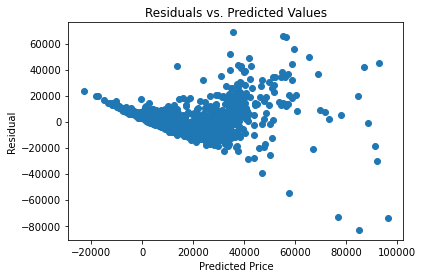

In [44]:
df_residual = pd.DataFrame()
df_residual['Predicted_Price'] = test_pred
df_residual['Residual']=df_test['Price']-df_residual['Predicted_Price']

plt.scatter(df_residual['Predicted_Price'], df_residual['Residual'])
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.title('Residuals vs. Predicted Values')
plt.show()

seats를 제외하고 돌린 회귀 결과의 결정 계수에 변화가 보이지 않으므로 Engine를 제외한 모델로 최종 회귀식으로 사용해도 될 것으로 보인다.
최종 test에 대한 결정계수는 0.757으로 높은 값은 아니다. 수치형 변수의 회귀 계수를 해석해보면

- power가 한 단위 증가하면 중고자 가격이 7279 증가하고, 
- 연료의 종류가 petrol이면 중고차 가격이 감소할 경향을 보인다( 회귀 계수가 음수이기 때문이다)
- 브랜드가 BMW이면 중고차 가격이 높아지는 경향을 보인다. ( 회귀 계수가 양이기 떄문이다)

<AxesSubplot:>

<Figure size 1080x720 with 0 Axes>

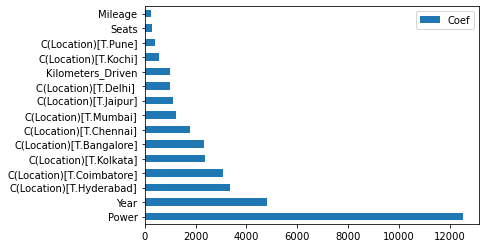

In [12]:
# 변수 중요도 그리기
reg_summary = reg_result.summary()

# 변수명을 포함하는 테이블을 찾음
tables = reg_summary.tables

name = []
for i in range(1, 16):
    name.append(tables[1].data[i][0])
name.append('Seats')

df_reg_coef = pd.DataFrame({"Coef": sorted(np.abs(reg_result.params.values[1:]), reverse=True)}, 
                           index=['Power', 'Year', 'C(Location)[T.Hyderabad]', 'C(Location)[T.Coimbatore]',
                                  'C(Location)[T.Kolkata]', 'C(Location)[T.Bangalore]', 'C(Location)[T.Chennai]',
                                  'C(Location)[T.Mumbai]', 'C(Location)[T.Jaipur]', 'C(Location)[T.Delhi] ',
                                  'Kilometers_Driven', 'C(Location)[T.Kochi]', 'C(Location)[T.Pune]', 'Seats', 'Mileage'])
plt.figure(figsize=(15,10))
df_reg_coef.plot.barh(y="Coef")


In [38]:
np.abs(df_reg_coef["Coef"]).sort_values(ascending=False)

Power                        12518.119428
Year                          4792.322769
C(Location)[T.Hyderabad]      3368.376383
C(Location)[T.Coimbatore]     3094.717543
C(Location)[T.Kolkata]        2387.616131
C(Location)[T.Bangalore]      2331.859170
C(Location)[T.Chennai]        1788.944680
C(Location)[T.Mumbai]         1247.166176
C(Location)[T.Jaipur]         1118.893016
C(Location)[T.Delhi]          1000.379276
Kilometers_Driven              992.605864
C(Location)[T.Kochi]           582.807433
C(Location)[T.Pune]            403.917910
Seats                          309.869229
Mileage                        270.090139
Name: Coef, dtype: float64

# 2. 규제화 회귀

---- 규제화 회귀를 위한 데이터 불러오기 ( 규제화 회귀의 데이터세트는 범주형 변수들이 전처리 과정에서 인코딩 되어있다.)

In [45]:
df = pd.read_csv("df_preprocessed1.csv")
df.head()

,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,...,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune
0,2682.68,2010,72000,1,1,4,26.60,998.0,58.16,5.0,...,0,0,0,0,0,0,0,0,1,0
1,19162.00,2015,41000,3,1,4,19.67,1582.0,126.20,5.0,...,0,0,0,0,0,0,0,0,0,1
2,6898.32,2011,46000,2,1,4,18.20,1199.0,88.70,5.0,...,0,1,0,0,0,0,0,0,0,0
3,9197.76,2012,87000,3,1,4,20.77,1248.0,88.76,7.0,...,0,1,0,0,0,0,0,0,0,0
4,27194.71,2013,40670,3,2,3,15.20,1968.0,140.80,5.0,...,0,0,1,0,0,0,0,0,0,0


설명변수들의 단위 차이 등으로 인해 생기는 값의 차이를 없애기 위해 표준화를 실시한다.

In [46]:
# Standard객체 생성
mm_scaler = StandardScaler()

df_x = df.drop("Price", axis = 1)
df_scaled_x = pd.DataFrame(mm_scaler.fit_transform(df_x), columns = df_x.columns)
df_scaled_x.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Name_Ambassador,...,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune
0,-1.063423,0.395601,-2.925664,-0.634723,0.439068,1.964702,-1.042239,-1.024935,-0.349325,-0.012749,...,-0.249654,-0.297727,-0.347219,-0.318287,-0.373705,-0.271357,-0.350443,-0.312368,2.566501,-0.335946
1,0.473632,-0.425658,0.914680,-0.634723,0.439068,0.305446,-0.059990,0.254696,-0.349325,-0.012749,...,-0.249654,-0.297727,-0.347219,-0.318287,-0.373705,-0.271357,-0.350443,-0.312368,-0.389635,2.976672
2,-0.756012,-0.293197,-1.005492,-0.634723,0.439068,-0.046518,-0.704171,-0.450568,-0.349325,-0.012749,...,-0.249654,3.358785,-0.347219,-0.318287,-0.373705,-0.271357,-0.350443,-0.312368,-0.389635,-0.335946
3,-0.448601,0.792985,0.914680,-0.634723,0.439068,0.568820,-0.621756,-0.449440,2.139842,-0.012749,...,-0.249654,3.358785,-0.347219,-0.318287,-0.373705,-0.271357,-0.350443,-0.312368,-0.389635,-0.335946
4,-0.141190,-0.434401,0.914680,1.575491,-1.786289,-0.764810,0.589237,0.529279,-0.349325,-0.012749,...,-0.249654,-0.297727,2.880028,-0.318287,-0.373705,-0.271357,-0.350443,-0.312368,-0.389635,-0.335946


예측 모델에 사용하기 위해 필요한 셋을 만들기 위하여 데이터 분할을 먼저 실시한다.

In [47]:
# df_scaled_x는 위에 생성되어 있다. 
df_scaled_y = df["Price"]

df_scaled_train_x, df_scaled_test_x, df_scaled_train_y, df_scaled_test_y = train_test_split(df_scaled_x, df_scaled_y, test_size=0.3, random_state=500)
print('scaled train data X size :{}'.format(df_scaled_train_x.shape))
print('scaled train data Y size :{}'.format(df_scaled_train_y.shape))
print('scaled test data X size :{}'.format(df_scaled_test_x.shape))
print('scaled test data Y size :{}'.format(df_scaled_test_y.shape))

scaled train data X size :(4307, 49)
scaled train data Y size :(4307,)
scaled test data X size :(1846, 49)
scaled test data Y size :(1846,)


## Ridge

- 가능한 성능이 좋은 모델을 만들기 위하여 파라미터 값을 조정한다.
- alpha의 값을 (0, 0.1, ,,,.1)로 지정하였는데 너무 작은 alpha의 값은 모델을 과적화 하거나 너무 큰 alpha는 모델 예측 성능을 저하시킬 수 있기 때문에 0~1 사이에서 0.1 씩 변화를 주며 모델 정확도를 확인한다.

In [48]:
train_accuracy = []; test_accuracy = []
MAPE = []

para_alpha = [ i for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]]
para_alpha = np.array(para_alpha)

for v_alpha in para_alpha: 
    ridge = Ridge(random_state=500, alpha=v_alpha)
    ridge.fit(df_scaled_train_x, df_scaled_train_y)
    train_pred = ridge.predict(df_scaled_train_x)
    test_pred = ridge.predict(df_scaled_test_x)
    train_accuracy.append(r2_score(df_scaled_train_y, train_pred))
    test_accuracy.append(r2_score(df_scaled_test_y, test_pred))
    MAPE.append(mean_absolute_percentage_error(df_scaled_test_y, test_pred))

# 데이터 테이블로 저장
df_accuracy_alpha = pd.DataFrame()
df_accuracy_alpha["Alpha"] = para_alpha
df_accuracy_alpha["TrainAccuracy"] = train_accuracy
df_accuracy_alpha["TestAccuracy"] = test_accuracy
df_accuracy_alpha["MAPE"] = MAPE

# 정확도 확인하기
df_accuracy_alpha.round(3)

,Alpha,TrainAccuracy,TestAccuracy,MAPE
0,0.1,0.756,0.765,0.602
1,0.2,0.756,0.765,0.602
2,0.3,0.756,0.765,0.602
3,0.4,0.756,0.765,0.602
4,0.5,0.756,0.765,0.602
5,0.6,0.756,0.765,0.602
6,0.7,0.756,0.765,0.602
7,0.8,0.756,0.765,0.602
8,0.9,0.756,0.765,0.602
9,1.0,0.756,0.765,0.602


alpha의 변화에 따른 모델의 정확도를 보면 alpha의 값에 따른 정확도에 차이가 없다. 따라서 alpha 값은 기본 1로 지정해도 괜찮을 것으로 보인다.

In [49]:
# alpha = 1인 릿지 회귀 모델 적합
ridge = Ridge(random_state=500, alpha=1)
ridge.fit(df_scaled_train_x, df_scaled_train_y)
print("Ridge의 절편:", ridge.intercept_)

Ridge의 절편: 14796.156931858026


In [50]:
# 회귀계수 확인
df_ridge_coef = pd.DataFrame({'Coef': ridge.coef_}, index=df_scaled_train_x.columns)
df_ridge_coef.sort_values("Coef")

,Coef
Name_Mahindra,-1456.319319
Name_Honda,-1262.269672
Name_Hyundai,-1247.960192
Kilometers_Driven,-989.634099
Name_Bentley,-942.697267
Name_Volkswagen,-850.020549
Name_Tata,-803.396761
Location_Kolkata,-743.448313
Name_Maruti,-690.497677
Name_Renault,-654.005949


<Axes: >

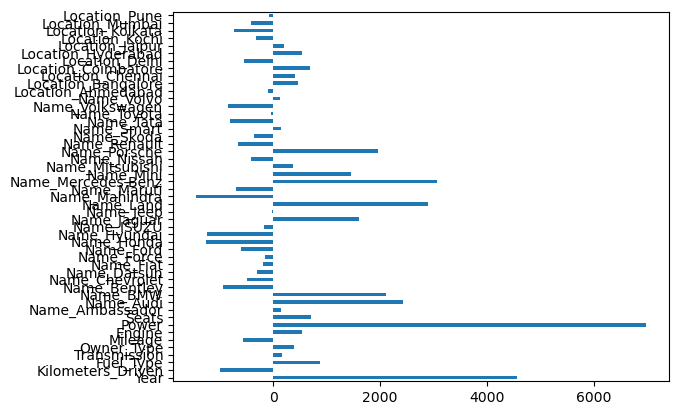

In [17]:
#회귀계수 그래프
df_ridge_coef.plot.barh(y='Coef', legend=False)

In [52]:
df_ridge_coef["Coef"].sort_values(ascending=False)

Power                  6990.552878
Year                   4557.651905
Name_Mercedes-Benz     3074.076765
Name_Land              2896.883849
Name_Audi              2439.713811
Name_BMW               2115.883765
Name_Porsche           1960.981867
Name_Jaguar            1603.941281
Name_Mini              1457.012576
Fuel_Type               881.086259
Seats                   711.848911
Location_Coimbatore     688.480562
Engine                  541.723921
Location_Hyderabad      531.362728
Location_Bangalore      462.017212
Location_Chennai        402.941387
Owner_Type              380.088497
Name_Mitsubishi         371.221769
Location_Jaipur         201.919219
Transmission            170.995812
Name_Ambassador         145.895396
Name_Smart              140.146180
Name_Volvo              119.688570
Name_Jeep               -31.306750
Name_Toyota             -34.765073
Location_Pune           -82.127899
Location_Ahmedabad      -97.780059
Name_Force             -156.341360
Name_ISUZU          

회귀계수가 0에 가까운 변수는 보이지 않는 것으로 보인다. 릿지에서는 Power의 계수가 6090으로 가장 변수 영향력이 높고 그다음은 year가 높다. Name_Mahindra의 회귀 계수가 다른 변수에 비해 가장 작다. 고가의 차량 브랜드는 중고차 가격이 높기 때문에 다른 차량 종류와는 다르게 회귀 계수에 영향을 많이 주는 것으로 보인다.( bmw, 아우디, 벤츠 등). 

In [18]:
#릿지 모델 - 모델 성능
train_pred = ridge.predict(df_scaled_train_x)
test_pred = ridge.predict(df_scaled_test_x)
print('train data 결정계수 :', r2_score(df_scaled_train_y, train_pred))
print('test data 결정계수 :', r2_score(df_scaled_test_y, test_pred))
print("Lasso MAPE:", mean_absolute_percentage_error(df_scaled_test_y, test_pred))

train data 결정계수 : 0.7560237277411094
test data 결정계수 : 0.7652473163841789
Lasso MAPE: 0.6017871587596665


## Lasso

앞에서 진행한 Ridge와 같이 최적의 alpha 값을 찾는다

In [53]:
train_accuracy = []; test_accuracy = []
MAPE = []

para_alpha = [ i for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]]
para_alpha = np.array(para_alpha)

for v_alpha in para_alpha: 
    lasso = Lasso(random_state=500, alpha=v_alpha)
    lasso.fit(df_scaled_train_x, df_scaled_train_y)
    train_pred = lasso.predict(df_scaled_train_x)
    test_pred = lasso.predict(df_scaled_test_x)
    train_accuracy.append(r2_score(df_scaled_train_y, train_pred))
    test_accuracy.append(r2_score(df_scaled_test_y, test_pred))
    MAPE.append(mean_absolute_percentage_error(df_scaled_test_y, test_pred))

# 데이터 테이블로 저장
df_accuracy_alpha = pd.DataFrame()
df_accuracy_alpha["Alpha"] = para_alpha
df_accuracy_alpha["TrainAccuracy"] = train_accuracy
df_accuracy_alpha["TestAccuracy"] = test_accuracy
df_accuracy_alpha["MAPE"] = MAPE

# 정확도 확인하기
df_accuracy_alpha.round(3)

C:\Users\Ayeon.DESKTOP-JBMJGTS\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e+10, tolerance: 1.247e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ayeon.DESKTOP-JBMJGTS\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e+10, tolerance: 1.247e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ayeon.DESKTOP-JBMJGTS\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

,Alpha,TrainAccuracy,TestAccuracy,MAPE
0,0.1,0.756,0.765,0.602
1,0.2,0.756,0.765,0.602
2,0.3,0.756,0.765,0.602
3,0.4,0.756,0.765,0.602
4,0.5,0.756,0.765,0.602
5,0.6,0.756,0.765,0.602
6,0.7,0.756,0.765,0.602
7,0.8,0.756,0.765,0.602
8,0.9,0.756,0.765,0.602
9,1.0,0.756,0.765,0.602


alpha의 값에 변화를 줘도 모델들의 정확도에 따른 차이가 보이지 않는다. 따라서 alpha의 기본 값인 1로 모델을 적합한다.

In [20]:
# alpha = 1인 라쏘 모델 생성
lasso = Lasso(random_state=500, alpha=1)
lasso.fit(df_scaled_train_x, df_scaled_train_y)
print(lasso.intercept_)

14796.063078481728


C:\Users\Ayeon.DESKTOP-JBMJGTS\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.759e+08, tolerance: 1.247e+08
  model = cd_fast.enet_coordinate_descent(


In [21]:
# 회귀계수 확인
df_lasso_coef = pd.DataFrame({'Coef': lasso.coef_}, index=df_scaled_train_x.columns)
df_lasso_coef.sort_values("Coef")

,Coef
Name_Mahindra,-998.567627
Kilometers_Driven,-987.602369
Name_Bentley,-915.132900
Location_Kolkata,-665.083118
Name_Honda,-606.464028
Mileage,-565.524681
Location_Delhi,-467.049810
Name_Tata,-419.770341
Name_Hyundai,-405.254681
Name_Volkswagen,-363.634189


<Axes: >

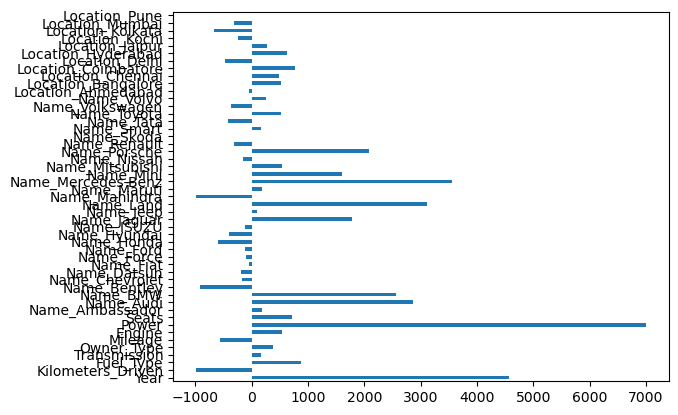

In [22]:
#회귀계수 그래프
df_lasso_coef.plot.barh(y='Coef', legend=False)

In [54]:
df_lasso_coef["Coef"].sort_values(ascending=False)

Power                  7005.749962
Year                   4557.418310
Name_Mercedes-Benz     3560.116730
Name_Land              3103.350002
Name_Audi              2860.087477
Name_BMW               2556.954694
Name_Porsche           2076.799989
Name_Jaguar            1781.737729
Name_Mini              1605.419980
Fuel_Type               880.614786
Location_Coimbatore     772.337977
Seats                   711.485307
Location_Hyderabad      620.417768
Name_Mitsubishi         532.433106
Engine                  531.638922
Location_Bangalore      524.946162
Name_Toyota             517.192182
Location_Chennai        476.192377
Owner_Type              378.689683
Location_Jaipur         269.736328
Name_Volvo              245.182731
Name_Maruti             184.247534
Name_Ambassador         173.278559
Transmission            170.455011
Name_Smart              167.238255
Name_Jeep                88.284667
Name_Skoda                9.482400
Location_Pune             0.000000
Location_Ahmedabad  

라쏘 추정에서도 Power, year가 중요하게 나오는 것으로 보인다. 릿지와 결과가 비슷한 것으로 판단됨.

In [56]:
#라쏘 모델 - 모델 성능
train_pred = lasso.predict(df_scaled_train_x)
test_pred = lasso.predict(df_scaled_test_x)
print('train data 결정계수 :', r2_score(df_scaled_train_y, train_pred))
print('test data 결정계수 :', r2_score(df_scaled_test_y, test_pred))
print("Lasso MAPE:", mean_absolute_percentage_error(df_scaled_test_y, test_pred))

train data 결정계수 : 0.7560236186241376
test data 결정계수 : 0.7652568114249191
Lasso MAPE: 0.6017500311411642


## Elastic Net

In [57]:
train_accuracy = []; test_accuracy = []
MAPE = []

para_alpha = [ i for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]]
para_alpha = np.array(para_alpha)

# para_ratio = [ i for i in [0,0, 0.1, 0.2, 0.3 ]]

for v_alpha in para_alpha:
    elastic = ElasticNet(random_state=500, alpha=v_alpha, l1_ratio=0.5)
    elastic.fit(df_scaled_train_x, df_scaled_train_y)
    train_pred = lasso.predict(df_scaled_train_x)
    test_pred = lasso.predict(df_scaled_test_x)
    train_accuracy.append(r2_score(df_scaled_train_y, train_pred))
    test_accuracy.append(r2_score(df_scaled_test_y, test_pred))
    MAPE.append(mean_absolute_percentage_error(df_scaled_test_y, test_pred))

# 데이터 테이블로 저장
df_accuracy_alpha = pd.DataFrame()
df_accuracy_alpha["Alpha"] = para_alpha
#df_accuracy_alpha["Ratio"] = para_ratio
df_accuracy_alpha["TrainAccuracy"] = train_accuracy
df_accuracy_alpha["TestAccuracy"] = test_accuracy
df_accuracy_alpha["MAPE"] = MAPE

# 정확도 확인하기
df_accuracy_alpha.round(3)

,Alpha,TrainAccuracy,TestAccuracy,MAPE
0,0.1,0.756,0.765,0.602
1,0.2,0.756,0.765,0.602
2,0.3,0.756,0.765,0.602
3,0.4,0.756,0.765,0.602
4,0.5,0.756,0.765,0.602
5,0.6,0.756,0.765,0.602
6,0.7,0.756,0.765,0.602
7,0.8,0.756,0.765,0.602
8,0.9,0.756,0.765,0.602
9,1.0,0.756,0.765,0.602


In [58]:
#Elasitic Net - 절편 확인
elastic = ElasticNet(random_state=500, alpha=1, l1_ratio=0.5)
elastic.fit(df_scaled_train_x, df_scaled_train_y)
print(elastic.intercept_)

14760.817009994511


In [59]:
# 회귀계수 확인
df_elastic_coef = pd.DataFrame({'Coef': elastic.coef_}, index=df_scaled_train_x.columns)
df_elastic_coef.sort_values("Coef")

,Coef
Kilometers_Driven,-1123.947242
Name_Mahindra,-846.212665
Name_Honda,-842.887108
Name_Hyundai,-802.344102
Mileage,-697.315029
Name_Volkswagen,-626.136101
Location_Kolkata,-613.274593
Name_Bentley,-582.757870
Name_Tata,-543.882846
Name_Maruti,-457.060379


<Axes: >

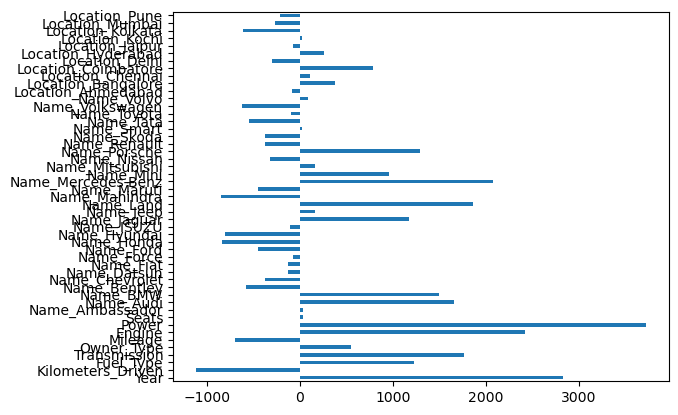

In [60]:
#회귀계수 그래프
df_elastic_coef.plot.barh(y='Coef', legend=False)

In [61]:
df_elastic_coef["Coef"].sort_values(ascending=False)

Power                  3724.965891
Year                   2832.484141
Engine                 2416.343445
Name_Mercedes-Benz     2071.257514
Name_Land              1861.203552
Transmission           1761.704148
Name_Audi              1657.179391
Name_BMW               1494.633056
Name_Porsche           1288.742134
Fuel_Type              1226.318312
Name_Jaguar            1170.860944
Name_Mini               952.993601
Location_Coimbatore     787.278269
Owner_Type              553.166052
Location_Bangalore      380.918893
Location_Hyderabad      260.814637
Name_Jeep               156.782020
Name_Mitsubishi         156.087563
Location_Chennai        102.532873
Name_Volvo               83.458018
Name_Ambassador          35.900517
Seats                    33.246599
Name_Smart               22.443773
Location_Kochi           16.368692
Location_Jaipur         -75.004671
Name_Force              -78.454454
Location_Ahmedabad      -85.113849
Name_Toyota             -96.105242
Name_ISUZU          

엘라스틱 넷에서는 다른 회귀결과와 다르게 Power, Year, Engine이 중요한 변수로 나타났다.     

In [62]:
#Elasitic Net 모델 - 모델 성능
train_pred = elastic.predict(df_scaled_train_x)
test_pred = elastic.predict(df_scaled_test_x)
print('train data 결정계수 :', r2_score(df_scaled_train_y, train_pred))
print('test data 결정계수 :', r2_score(df_scaled_test_y, test_pred))
print("Elastic Net MAPE:", mean_absolute_percentage_error(df_scaled_test_y, test_pred))

train data 결정계수 : 0.7225135742505626
test data 결정계수 : 0.7378134232743476
Elastic Net MAPE: 0.4663776129141653


In [63]:
# StandardScaler를 적용했을 때 다중회귀와, 규제화 회귀 모델 최종 결과

import pandas as pd

total = pd.DataFrame({
    "NAME": ["Liner_regression", "Ridge", "Lasso", "Elastic Net"],
    "r2_score train": [0.757, 0.756, 0.756, 0.723],
    "r2_score test": [0.765, 0.765, 0.765, 0.738],
    "MAPE": [0.604, 0.602, 0.602, 0.466]
})

total

,NAME,r2_score train,r2_score test,MAPE
0,Liner_regression,0.757,0.765,0.604
1,Ridge,0.756,0.765,0.602
2,Lasso,0.756,0.765,0.602
3,Elastic Net,0.723,0.738,0.466


- MAPE = MAPE는 예측 오차를 백분율로 나타낸 값

Train Accuracy 기준으로 보면 Elastic net을 제외한 3개의 모델의 결정계수는 거의 같다. MAPE 평가 지표를 기준으로 보면 라쏘와 릿지의 MAPE가 0.602으로 가장 높고, 엘라스틱 넷의 MAPE가 0.466으로 가장 낮다. 결정 계수는 클수록 모델의 설명력이 좋고 MAPE는 낮을 수록 모델 예측 성능이 좋다.
가장 좋은 예측 모델은 엘라스틱 넷이다.